# Project 4 - WeRateDogs


## Analysis Structure:

#### | Importing libraries

#### | Gathering Data

#### | Assessing Data

#### | Cleaning Data

#### | Analysis and Visualization

## Importing Libraries

In [1]:
# importing all packages needed
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
import tweepy 
import requests 
import json 
from collections import Counter 

## Gathering Data

In [2]:
# Read CSV file of twitter archive into dataframe
twitter_file = pd.read_csv('twitter-archive-enhanced.csv')

# get familiar with dataframe
twitter_file.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# Gather more info about the dataframe
twitter_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [4]:
# Use requests library to programmatically download tsv file from a website
url= 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open('image_predictions.tsv', 'wb') as file:
    file.write(response.content)
    
# Read tsv file into dataframe
img_prediction = pd.read_csv('image_predictions.tsv', sep='\t')

In [5]:
# get familiar with this dataframe
img_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


I will use here the already available "tweet-json.txt" file in the udacity project description instead of using Tweepy to query Twitter's API.

In [6]:
# As we already have the file "tweet-json.txt"
# we will have a For loop to append each tweet into a new created list

tweets_data = []

tweet_file = open('tweet_json.txt', "r")

for line in tweet_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue
        
tweet_file.close()

In [7]:
# Create tweet_info DataFrame
tweet_info = pd.DataFrame()

In [8]:
# Add selected variables to tweet_info DataFrame

tweet_info['id'] = list(map(lambda tweet: tweet['id'], tweets_data))
tweet_info['retweet_count'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))
tweet_info['favorite_count'] = list(map(lambda tweet: tweet['favorite_count'], tweets_data))

In [9]:
# make sure tweet_info dataframe contains the required info 
tweet_info.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


## Assessing our data

Let's have a look on the data we have now, review its content to clean it and remove any unwanted data

In [10]:
#let's view the first 10 lines of the twitter archive file
twitter_file.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [11]:
# now let's check the info of this file
twitter_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [12]:
# let's have an overview of the stats of the twitter archive file
twitter_file.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [13]:
# now let's take a look at the image prediction file
img_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [14]:
# let's view some info of this file
img_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [15]:
# let's have an overview of some stats of the image prediction file
img_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [16]:
# now let's have a closer look at the tweet_info dataframe extracted from the JSON file
tweet_info.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [17]:
#let's have some info of this file
tweet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
id                2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
dtypes: int64(3)
memory usage: 55.2 KB


In [18]:
# Let's see some stats of this file as well
tweet_info.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


In [19]:
# check if there are any duplicate IDs in our twitter archive file
twitter_file.tweet_id.duplicated().sum()

0

From the above we can see there are no duplicate IDs

In [20]:
# let's check also if there are any duplicate IDs in the tweet_info dataframe
tweet_info.id.duplicated().sum()

0

From the above we can see there are no duplicate IDs in the tweet_info file as well.

In [21]:
# now let's check for the original tweets and the retweets
twitter_file['retweeted_status_id'].isnull().sum()

2175

We can conclude that there are 2175 original tweets, and the rest are retweets

In [22]:
# We can also see the value counts of the twitter_file 
twitter_file.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Oliver         11
Lucy           11
Lola           10
Penny          10
Tucker         10
Bo              9
Winston         9
the             8
Sadie           8
Daisy           7
Bailey          7
Toby            7
an              7
Buddy           7
Milo            6
Leo             6
Jax             6
Koda            6
Bella           6
Jack            6
Rusty           6
Stanley         6
Scout           6
Dave            6
Oscar           6
Larry           5
             ... 
Chevy           1
Franq           1
Alf             1
Cheryl          1
Bronte          1
Banjo           1
Cuddles         1
Lassie          1
Zuzu            1
Barry           1
Ralphus         1
Dallas          1
Kara            1
Gerbald         1
Nimbus          1
Furzey          1
Ralphson        1
Kendall         1
Longfellow      1
Staniel         1
Lucky           1
Tycho           1
Rover           1
Jeffrie         1
Autumn    

In [23]:
# let's also check on the names
twitter_file.loc[(twitter_file.name.str.islower())].name.value_counts()

a               55
the              8
an               7
very             5
quite            4
one              4
just             4
actually         2
getting          2
not              2
mad              2
infuriating      1
by               1
incredibly       1
space            1
such             1
this             1
old              1
life             1
officially       1
light            1
all              1
unacceptable     1
his              1
my               1
Name: name, dtype: int64

We can see from the above that not all the names we have are REAL names

In [24]:
twitter_file['expanded_urls'].isna().sum()

59

From the above we can see some tweets have missing values and needs to be dropped

In [25]:
# let's check for duplicates in the image prediction file
img_prediction['jpg_url'].duplicated().sum()

66

From the above we can see there are duplicates that need to be dropped

Quality issues we found in our data :<br>
1- The timestamp type should be changed as datetime instead of string <br>
2- Need to remove the retweets <br>
3- Remove column related to retweets as they are all empty now. <br>
4- Dog names doesn't make sense like : 'a', 'the', 'an' ..etc <br>
5- Some tweets don’t include images <br>
6- Missing values in 'name' and should be replaced by 'None' <br>
7- Extra "amp;" that is used in coding after "&"  <br>
8- There are Sources that are difﬁcult to read <br>
9- Duplicates in the images url in image predictions ﬁle need to be dropped

Tidiness issues : <br>
1- Dog "stage" variable in four columns : "doggo", "floofer", "'pupper" and "puppo" <br>
2- "tweet_info" and "img_prediction" needs to be joined to "twitter_file"

## Cleaning Data

Let's first have a copy of all the original dataframes so that we work on these instead of the original ones.

In [26]:
#copying the original dataframes 
twitter_archive_clean = twitter_file.copy()
image_predictions_clean = img_prediction.copy()
tweet_info_clean = tweet_info.copy()

### 1- Timestamp should be changed from string type to datetime type

In [27]:
tweet_info_clean.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [28]:
twitter_file.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [29]:
## fixing issue 1 There are duplicates in tweet_id of tweet_info file and need to be dropped
tweet_info_clean.id.drop_duplicates(inplace=True)

In [30]:
## testing the function
tweet_info_clean.id.duplicated().sum()

0

In [31]:
## testing the function
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [32]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

As you can see above, the timestamp column type is object

In [33]:
# changing type to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp']) 

In [34]:
# confirm that type is changed
twitter_archive_clean['timestamp'].head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

Now the type is changed to datetime and is read correctly

### 2- Need to remove the retweets


In [35]:
# keeping only the rows that do not have retweets IDs as these are the original ones
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_id'])]

In [36]:
# confirm it ran correctly
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), flo

From the above we can see that there are no retweeted IDs anymore.

### 3- Remove column related to retweets as they are all empty now.

In [37]:
# create a variable for the column names
names = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']

# drop columns included in this variable
twitter_archive_clean = twitter_archive_clean.drop(names, axis=1)

In [38]:
# confirm the columns are dropped
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 254.9+ KB


From the above we can see that the 3 columns do not exist

### 4- Dog names doesn't make sense like : 'a', 'the', 'an' ..etc

In [39]:
# variable holding all unwanted names
not_names = ['a', 'the', 'an', 'very', 'just', 'quite', 'one', 'actually', 'getting', 'not', 'mad', 'old', 'space', 'unacceptable', 'all', 'such', 'incredibly', 'this', 'by', 'officially', 'my', 'life', 'light', 'infuriating', 'his']

# replacing the unwanted names by 'None'
for name in not_names:
    twitter_archive_clean.loc[twitter_archive_clean.name == name, 'name'] = None

In [40]:
# confirm names are replaced by 'None'
twitter_archive_clean.name.value_counts()

None          680
Lucy           11
Charlie        11
Oliver         10
Cooper         10
Penny           9
Tucker          9
Sadie           8
Lola            8
Winston         8
Daisy           7
Toby            7
Jax             6
Stanley         6
Oscar           6
Bo              6
Bella           6
Bailey          6
Koda            6
Rusty           5
Milo            5
Chester         5
Scout           5
Louis           5
Buddy           5
Leo             5
Bentley         5
Dave            5
Sammy           4
Finn            4
             ... 
Smiley          1
Tupawc          1
Severus         1
Stubert         1
Karma           1
Nollie          1
Rover           1
Tycho           1
Kara            1
Eazy            1
Remy            1
Odin            1
Shooter         1
Shadoe          1
Lassie          1
Barry           1
Ralphus         1
Dallas          1
Gromit          1
Lucky           1
Harper          1
Gerbald         1
Nimbus          1
Furzey          1
Carly     

### 5- Some tweets don’t include images

In [41]:
# dropping tweets that do not include images
twitter_archive_clean = twitter_archive_clean.dropna(subset=['expanded_urls'])

In [42]:
# confirm they are dropped
twitter_archive_clean['expanded_urls'].isna().sum()

0

### 6- Missing values in 'name' and should be replaced by 'None'

In [43]:
# Replacing missing values by 'None'
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace('None', np.NaN)

In [44]:
# confirm replacement
twitter_archive_clean.name.value_counts()

Lucy          11
Charlie       11
Cooper        10
Oliver        10
Penny          9
Tucker         9
Sadie          8
Winston        8
Lola           8
Daisy          7
Toby           7
Koda           6
Jax            6
Bailey         6
Stanley        6
Oscar          6
Bella          6
Bo             6
Bentley        5
Dave           5
Rusty          5
Louis          5
Buddy          5
Milo           5
Leo            5
Scout          5
Chester        5
Bear           4
Maggie         4
Winnie         4
              ..
Jay            1
Smiley         1
Tupawc         1
Severus        1
Stubert        1
Rover          1
Tycho          1
Lucky          1
Dallas         1
Lacy           1
Eazy           1
Remy           1
Odin           1
Shooter        1
Shadoe         1
Lassie         1
Barry          1
Ralphus        1
Kara           1
Longfellow     1
Gromit         1
Harper         1
Gerbald        1
Nimbus         1
Furzey         1
Carly          1
Ralphson       1
Kendall       

### 7- Extra "amp;" that is used in coding after "&"

In [45]:
# replace "&amp;" with "&"
twitter_archive_clean['text'] = twitter_archive_clean['text'].str.replace('&amp;', '&')

In [46]:
# confirm there in no "&amp;" 
twitter_archive_clean[twitter_archive_clean.text.str.contains('&amp;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


From the above you see it returns an empty dataframe, so there is it was replaced successfully

### 8- There are Sources that are difﬁcult to read

In [47]:
# reading values of the source column
twitter_archive_clean['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1985
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       30
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

We can see that the Source values contain the URL which makes it hard to read

In [48]:
# Replacing sources with URL with ones without URL 
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>', 'Twitter for iPhone')
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>', 'Vine')
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>', 'Twitter Web Client')
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>', 'TweetDeck')

In [49]:
#Confirming that they are replaced
twitter_archive_clean['source'].value_counts()

Twitter for iPhone    1985
Vine                    91
Twitter Web Client      30
TweetDeck               11
Name: source, dtype: int64

### 9- Duplicates in the images url in image predictions ﬁle need to be dropped

In [50]:
# check for duplicates
image_predictions_clean['jpg_url'].duplicated().sum()

66

In [51]:
# remove duplicates
image_predictions_clean = image_predictions_clean.drop_duplicates(subset=['jpg_url'])

In [52]:
# confirm that duplicates were removed
image_predictions_clean['jpg_url'].duplicated().sum()

0

### Resolving Tidiness Issues

### 1- Dog "stage" variable in four columns : "doggo", "floofer", "'pupper" and "puppo"

In [53]:
# get a matrix of values
twitter_archive_clean.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index()

,doggo,floofer,pupper,puppo,0
0,None,None,None,None,1779
1,None,None,None,puppo,23
2,None,None,pupper,None,222
3,None,floofer,None,None,9
4,doggo,None,None,None,72
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,10
7,doggo,floofer,None,None,1


In [54]:
# replace 'None' values by ""
twitter_archive_clean['doggo'] = twitter_archive_clean['doggo'].replace('None', '') 
twitter_archive_clean['floofer'] = twitter_archive_clean['floofer'].replace('None', '')
twitter_archive_clean['pupper'] = twitter_archive_clean['pupper'].replace('None', '')
twitter_archive_clean['puppo'] = twitter_archive_clean['puppo'].replace('None', '')

In [55]:
# add a new column 'stage' and merge values to it
twitter_archive_clean['stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo  
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggopupper', 'stage'] = 'doggo,pupper'
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggopuppo', 'stage'] = 'doggo,puppo'
twitter_archive_clean.loc[twitter_archive_clean.stage == 'doggofloofer', 'stage'] = 'doggo,floofer'

In [56]:
# drop the 4 columns
twitter_archive_clean.drop(['doggo','floofer','pupper','puppo'], axis=1, inplace = True)

In [57]:
# make sure of the values compared to the above matrix
twitter_archive_clean.stage.value_counts()

                 1779
pupper            222
doggo              72
puppo              23
doggo,pupper       10
floofer             9
doggo,puppo         1
doggo,floofer       1
Name: stage, dtype: int64

### 2- "tweet_info" and "img_prediction" needs to be joined to "twitter_file"

In [58]:
# Change type of ID column in each dataframe to be string
tweet_info_clean['id'] = tweet_info_clean['id'].astype(str)
image_predictions_clean['tweet_id'] = image_predictions_clean['tweet_id'].astype(str)
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
tweet_info_clean.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [59]:
#merge first two dataframes into a new dataframe "twitter_archive_master"
twitter_archive_master = pd.merge(left=twitter_archive_clean, right=tweet_info_clean, left_on='tweet_id', right_on='id', how='inner')
twitter_archive_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage,id,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,,892420643555336193,8853,39467
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,,892177421306343426,6514,33819
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,,891815181378084864,4328,25461
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,,891689557279858688,8964,42908
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,,891327558926688256,9774,41048


In [61]:
# merge third dataframe with "twitter_archive_master"
twitter_archive_master = pd.merge(left = twitter_archive_master, right=image_predictions_clean, left_on='tweet_id', right_on ='tweet_id', how='inner')

In [62]:
# View data
twitter_archive_master.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,...,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,...,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,...,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


In [63]:
# let's save the new merged and cleaned dataframe to a csv file
twitter_archive_clean.to_csv('twitter_archive_master.csv')

## Analysis and Visualization

### First insight:

In [64]:
# get the value counts of the source column 
counts = twitter_archive_master.source.value_counts()
counts

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

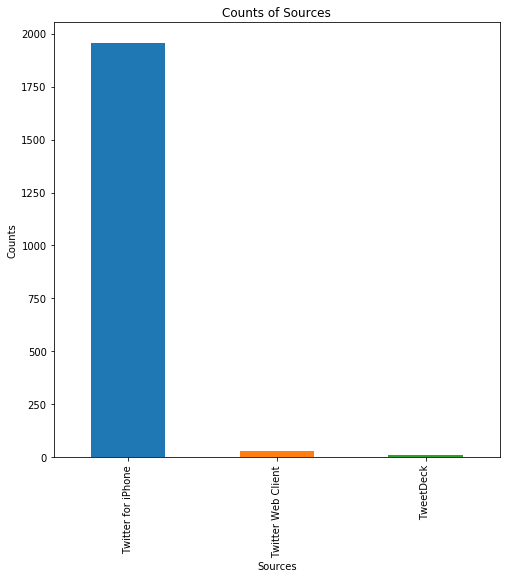

In [65]:
# Visualization of the above counts

counts.plot(kind = 'bar', title = 'Counts of Sources', figsize = (8,8))
plt.xlabel('Sources')
plt.ylabel('Counts');

plt.savefig('Counts of Sources.png')

We found that Twitter for iPhone has the highest numbers as shown in the below figure.
In second place comes Twitter Web Client, but there is a huge difference in numbers as you can see from the below chart.

### Second Insight:

In [66]:
most_common = twitter_archive_master.name.value_counts().head(7)
most_common

Charlie    11
Cooper     10
Lucy       10
Oliver     10
Penny       9
Tucker      9
Sadie       8
Name: name, dtype: int64

Top used name was “Charlie” as it appeared 11 times, while “Oliver” is the second most common name with 10 occurrences, which is the same number of occurrences for both “Lucy” and “Cooper”.

### Third Insight:

In [67]:
# get the top 10 breeds
P1_counts = twitter_archive_master.p1.value_counts().head(10) 
P1_counts

golden_retriever      139
Labrador_retriever     95
Pembroke               88
Chihuahua              79
pug                    54
chow                   41
Samoyed                40
Pomeranian             38
toy_poodle             38
malamute               29
Name: p1, dtype: int64

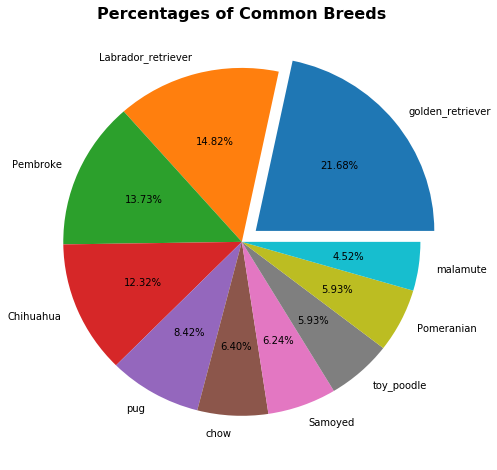

In [68]:
# Visualization of the above
explode = (0.1, 0, 0, 0,0,0,0,0,0,0)

P1_counts.sort_values(ascending=False).plot.pie(legend=False, subplots=True, autopct='%.2f%%', figsize= (8,8), explode = explode)
plt.ylabel('')
plt.title('Percentages of Common Breeds', weight='bold', fontsize=16)
plt.savefig('Breeds_Percentages.png')

From the Findings provided in the below figure, we can see that after checking for the 10 most common breeds, we found that the Golder Retriever is the most common breed with 21.68% of total people count.